In [1]:
COLLAB = True
if COLLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = "/content/drive/MyDrive/Kodiak/STORAGE/fake_slo/masks"
else:
    data_path = "masks"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import PIL

In [3]:
import os
from PIL import Image


for image_name in sorted(os.listdir(data_path)):
    image_path = os.path.join(data_path, image_name)
    if not os.path.isfile(image_path):
        continue
    if not image_name.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")):
        continue
    print(image_name)
    img = Image.open(image_path)
    # display(img)  # shows inline in notebook

DCFC_14Deg_12umCladding_Umit_00_mask_flipped.tiff
Integration_CT_L3_1frame_06_mask_flipped.tiff
slo_10_mask_mask.tiff
slo_11_mask_mask.tiff
slo_12_mask_mask.tiff
slo_13_mask_mask.tiff
slo_14_mask_mask.tiff
slo_18_mask_mask_flipped.tiff
slo_19_mask_mask_flipped.tiff
slo_1_mask_mask.tiff
slo_20_mask_mask_flipped.tiff
slo_21_mask_mask.tiff
slo_3_mask_mask.tiff
slo_4_mask_mask.tiff
slo_5_mask_mask.tiff
slo_6_mask_mask.tiff
slo_7_mask_mask.tiff
slo_8_mask_mask.tiff
slo_9_mask_mask.tiff
stitched_mask_mask_flipped.tiff
tc1_mask.tiff
vessels_1.tiff
vessels_10.tiff
vessels_11.tiff
vessels_12.tiff
vessels_13.tiff
vessels_14.tiff
vessels_15_flipped.tiff
vessels_16.tiff
vessels_17_flipped.tiff
vessels_18.tiff
vessels_19.tiff
vessels_2.tiff
vessels_20.tiff
vessels_21.tiff
vessels_22_flipped.tiff
vessels_3.tiff
vessels_4.tiff
vessels_5.tiff
vessels_6.tiff
vessels_7.tiff
vessels_8.tiff
vessels_9.tiff


In [4]:
!pip install numpy
!pip install tensorflow

## TensorFlow DDPM For Mask Synthesis
Train a diffusion model on your vessel masks and generate new synthetic binary masks.


In [6]:
# TensorFlow DDPM (Mask Synthesis)

import json
import math
import os
import random
from pathlib import Path

import numpy as np
import tensorflow as tf
from PIL import Image
from IPython.display import display

try:
    import jax
except Exception:
    jax = None

print("TensorFlow:", tf.__version__)

try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("TPU connected:", resolver.cluster_spec().as_dict())
except Exception as e:
    strategy = tf.distribute.get_strategy()
    print("No TPU detected, using:", type(strategy).__name__, "|", e)

print("TF logical TPUs:", tf.config.list_logical_devices("TPU"))
print("Num GPUs Available:", len(tf.config.list_physical_devices("GPU")))
if jax is not None:
    print("JAX devices:", jax.devices())

# Optional but useful in Colab to avoid full GPU pre-allocation.
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR = Path(data_path) if "data_path" in globals() else Path("masks")
MODEL_DIR = DATA_DIR.parent / "tf_ddpm_mask_model"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

IMAGE_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 200
LEARNING_RATE = 1e-5
DIFFUSION_STEPS = 1000
THRESHOLD = 0  # black stays 0, anything > 0 becomes vessel/white

image_files = sorted(
    str(p)
    for p in DATA_DIR.rglob("*")
    if p.is_file() and p.suffix.lower() in {".tif", ".tiff", ".png", ".jpg", ".jpeg"}
)
print(f"Found {len(image_files)} training images in {DATA_DIR}")
if not image_files:
    raise ValueError(f"No training images found in {DATA_DIR}")


def _load_mask_py(path_tensor):
    path = path_tensor.numpy().decode("utf-8")
    with Image.open(path) as img:
        img = img.convert("L")
        img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.Resampling.NEAREST)
        arr = np.array(img, dtype=np.uint8)

    arr = (arr > THRESHOLD).astype(np.float32)
    arr = arr[..., None]  # HWC with one channel
    arr = arr * 2.0 - 1.0  # scale to [-1, 1]
    return arr


def load_mask_tf(path_tensor):
    x = tf.py_function(_load_mask_py, [path_tensor], Tout=tf.float32)
    x.set_shape((IMAGE_SIZE, IMAGE_SIZE, 1))
    return x


dataset = (
    tf.data.Dataset.from_tensor_slices(image_files)
    .shuffle(len(image_files), seed=SEED, reshuffle_each_iteration=True)
    .map(load_mask_tf, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)
dist_dataset = strategy.experimental_distribute_dataset(dataset)


def sinusoidal_embedding(timesteps, dim=128):
    half = dim // 2
    freqs = tf.exp(-math.log(10000.0) * tf.range(half, dtype=tf.float32) / float(max(half - 1, 1)))
    args = tf.cast(tf.expand_dims(timesteps, 1), tf.float32) * tf.expand_dims(freqs, 0)
    emb = tf.concat([tf.sin(args), tf.cos(args)], axis=-1)
    if dim % 2 == 1:
        emb = tf.pad(emb, [[0, 0], [0, 1]])
    return emb


def residual_block(x, t_emb, channels, name):
    in_channels = x.shape[-1]

    h = tf.keras.layers.Conv2D(channels, 3, padding="same", name=f"{name}_conv1")(x)
    h = tf.keras.layers.BatchNormalization(name=f"{name}_bn1")(h)
    h = tf.keras.layers.Activation("swish", name=f"{name}_act1")(h)

    t_proj = tf.keras.layers.Dense(channels, activation="swish", name=f"{name}_tproj")(t_emb)
    t_proj = tf.keras.layers.Reshape((1, 1, channels), name=f"{name}_treshape")(t_proj)
    h = tf.keras.layers.Add(name=f"{name}_tadd")([h, t_proj])

    h = tf.keras.layers.Conv2D(channels, 3, padding="same", name=f"{name}_conv2")(h)
    h = tf.keras.layers.BatchNormalization(name=f"{name}_bn2")(h)
    h = tf.keras.layers.Activation("swish", name=f"{name}_act2")(h)

    if in_channels != channels:
        x = tf.keras.layers.Conv2D(channels, 1, padding="same", name=f"{name}_skip")(x)

    return tf.keras.layers.Add(name=f"{name}_out")([x, h])


def build_unet(image_size):
    image_in = tf.keras.Input(shape=(image_size, image_size, 1), name="image")
    t_in = tf.keras.Input(shape=(), dtype=tf.int32, name="timestep")

    t_emb = tf.keras.layers.Lambda(lambda t: sinusoidal_embedding(t, 128), name="time_sin")(t_in)
    t_emb = tf.keras.layers.Dense(256, activation="swish", name="time_dense1")(t_emb)
    t_emb = tf.keras.layers.Dense(256, activation="swish", name="time_dense2")(t_emb)

    x = tf.keras.layers.Conv2D(64, 3, padding="same", name="in_conv")(image_in)

    s1 = residual_block(x, t_emb, 64, "down1")
    x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same", name="downsample1")(s1)

    s2 = residual_block(x, t_emb, 128, "down2")
    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding="same", name="downsample2")(s2)

    x = residual_block(x, t_emb, 256, "mid1")
    x = residual_block(x, t_emb, 256, "mid2")

    x = tf.keras.layers.UpSampling2D(size=2, interpolation="nearest", name="upsample1")(x)
    x = tf.keras.layers.Concatenate(name="concat1")([x, s2])
    x = residual_block(x, t_emb, 128, "up1")

    x = tf.keras.layers.UpSampling2D(size=2, interpolation="nearest", name="upsample2")(x)
    x = tf.keras.layers.Concatenate(name="concat2")([x, s1])
    x = residual_block(x, t_emb, 64, "up2")

    out = tf.keras.layers.Conv2D(1, 1, padding="same", name="noise_pred")(x)
    return tf.keras.Model([image_in, t_in], out, name="mask_ddpm_unet")


with strategy.scope():
    model = build_unet(IMAGE_SIZE)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

betas = np.linspace(1e-4, 2e-2, DIFFUSION_STEPS, dtype=np.float32)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas, axis=0).astype(np.float32)

betas_tf = tf.constant(betas)
alphas_tf = tf.constant(alphas)
alpha_bars_tf = tf.constant(alpha_bars)


def q_sample(x0, t, noise):
    a_bar = tf.gather(alpha_bars_tf, t)
    a_bar = tf.reshape(a_bar, (-1, 1, 1, 1))
    return tf.sqrt(a_bar) * x0 + tf.sqrt(1.0 - a_bar) * noise


def step_fn(x0):
    b = tf.shape(x0)[0]
    t = tf.random.uniform((b,), minval=0, maxval=DIFFUSION_STEPS, dtype=tf.int32)
    noise = tf.random.normal(tf.shape(x0))
    x_t = q_sample(x0, t, noise)

    with tf.GradientTape() as tape:
        pred_noise = model([x_t, t], training=True)
        loss = tf.reduce_mean(tf.square(noise - pred_noise))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss


@tf.function
def distributed_train_step(dist_inputs):
    per_replica_losses = strategy.run(step_fn, args=(dist_inputs,))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)


for epoch in range(1, EPOCHS + 1):
    losses = []
    for batch in dist_dataset:
        loss = distributed_train_step(batch)
        losses.append(float(loss.numpy()))

    mean_loss = float(np.mean(losses)) if losses else float("nan")
    print(f"Epoch {epoch:03d}/{EPOCHS} | loss={mean_loss:.6f}")


weights_path = MODEL_DIR / "model.weights.h5"
model.save_weights(weights_path)

np.savez(
    MODEL_DIR / "schedule.npz",
    betas=betas,
    alphas=alphas,
    alpha_bars=alpha_bars,
)

(MODEL_DIR / "config.json").write_text(
    json.dumps(
        {
            "image_size": IMAGE_SIZE,
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "learning_rate": LEARNING_RATE,
            "diffusion_steps": DIFFUSION_STEPS,
            "threshold": THRESHOLD,
            "data_dir": str(DATA_DIR),
        },
        indent=2,
    ),
    encoding="utf-8",
)

print("Saved model to", MODEL_DIR)


TensorFlow: 2.20.0
No TPU detected, using: _DefaultDistributionStrategy | Please provide a TPU Name to connect to.
TF logical TPUs: []
Num GPUs Available: 0
JAX devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)]
Found 43 training images in /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/masks
Epoch 001/200 | loss=10.376638
Epoch 002/200 | loss=8.143998
Epoch 003/200 | loss=6.390876
Epoch 004/200 | loss=5.042482
Epoch 005/200 | loss=4.134451
Epoch 006/200 | loss=3.488679
Epoch 007/200 | loss=3.077368
Epoch 008/200 | loss=2.778560
Epoch 009/200 | loss=2.610032
Epoch 010/200 | loss=2.455197
Epoch 011/200 | loss=2.305440
Epoch 012/200 | loss=2.228268
Epoch 013/200 | loss=2.119436
Epoch 014/200 | loss=2.028803
Epoch 015/200 | loss=1.902367
Epoch 016/200 | loss=1.884207
Epoch 017/200 | loss=1.810416
Epoch 018/200 | loss=1.747871
Epoch 019/200 | loss=1.668711
Epoch 020/200 | loss=1.638061
Epoch 021/200 | loss=1.612011
Epoch 022/200 | loss=1.518553
Epoch 023/200 | loss=

Generating 0 of 10 masks
Generating 8 of 10 masks
Saved 10 synthetic masks to /content/drive/MyDrive/Kodiak/STORAGE/fake_slo/generated_masks_tf


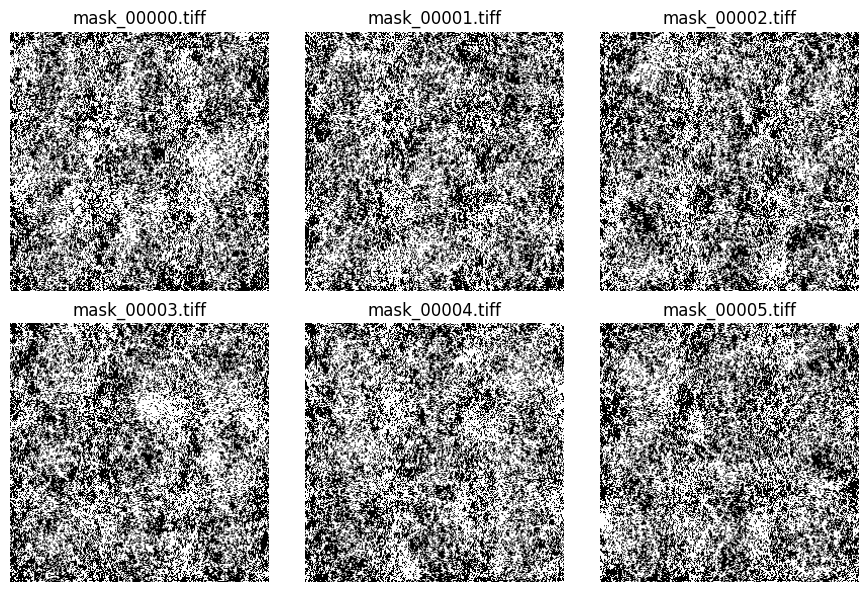

In [9]:
# Generate synthetic masks with trained TensorFlow DDPM
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image

if "build_unet" not in globals():
    raise RuntimeError("Run the TensorFlow DDPM training cell first (it defines build_unet).")
if "strategy" not in globals():
    strategy = tf.distribute.get_strategy()

MODEL_DIR = Path(data_path).parent / "tf_ddpm_mask_model" if "data_path" in globals() else Path("tf_ddpm_mask_model")
OUT_DIR = MODEL_DIR.parent / "generated_masks_tf"
OUT_DIR.mkdir(parents=True, exist_ok=True)

cfg_path = MODEL_DIR / "config.json"
if cfg_path.exists():
    cfg = json.loads(cfg_path.read_text(encoding="utf-8"))
    IMAGE_SIZE = int(cfg.get("image_size", globals().get("IMAGE_SIZE", 256)))
    DIFFUSION_STEPS = int(cfg.get("diffusion_steps", globals().get("DIFFUSION_STEPS", 1000)))
else:
    IMAGE_SIZE = int(globals().get("IMAGE_SIZE", 256))
    DIFFUSION_STEPS = int(globals().get("DIFFUSION_STEPS", 1000))

NUM_SAMPLES = 10
BATCH_SIZE = 8
INFERENCE_STEPS = 250
BINARY_THRESHOLD = 0.5

# Rebuild model and load weights/schedule.
with strategy.scope():
    model = build_unet(IMAGE_SIZE)
    model.load_weights(MODEL_DIR / "model.weights.h5")

sched = np.load(MODEL_DIR / "schedule.npz")
betas = sched["betas"].astype(np.float32)
alphas = sched["alphas"].astype(np.float32)
alpha_bars = sched["alpha_bars"].astype(np.float32)


def p_sample_loop(num_samples, batch_size, inference_steps):
    saved = 0
    sample_idx = 0

    while saved < num_samples:
        print(f"Generating {saved} of {num_samples} masks")
        current_batch = min(batch_size, num_samples - saved)
        x = tf.random.normal((current_batch, IMAGE_SIZE, IMAGE_SIZE, 1))

        for t in reversed(range(inference_steps)):
            t_batch = tf.fill([current_batch], t)
            eps_theta = model([x, t_batch], training=False)

            alpha_t = alphas[t]
            alpha_bar_t = alpha_bars[t]
            beta_t = betas[t]

            coef1 = 1.0 / np.sqrt(alpha_t)
            coef2 = (1.0 - alpha_t) / np.sqrt(1.0 - alpha_bar_t)

            if t > 0:
                z = tf.random.normal(tf.shape(x))
            else:
                z = tf.zeros_like(x)

            x = coef1 * (x - coef2 * eps_theta) + np.sqrt(beta_t) * z

        x_np = x.numpy()
        x_np = (x_np + 1.0) / 2.0
        x_np = np.clip(x_np, 0.0, 1.0)

        for i in range(current_batch):
            gray = x_np[i, ..., 0]
            binary = (gray > BINARY_THRESHOLD).astype(np.uint8) * 255
            out_path = OUT_DIR / f"mask_{sample_idx:05d}.tiff"
            Image.fromarray(binary, mode="L").save(out_path, format="TIFF")
            sample_idx += 1
            saved += 1

            if saved >= num_samples:
                break

    return sample_idx


count = p_sample_loop(NUM_SAMPLES, BATCH_SIZE, INFERENCE_STEPS)
print(f"Saved {count} synthetic masks to {OUT_DIR}")

# Quick preview of first 6 generated masks.
preview = sorted(OUT_DIR.glob("mask_*.tiff"))[:6]
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for ax, p in zip(axes.flatten(), preview):
    with Image.open(p) as img:
        ax.imshow(img, cmap="gray")
    ax.set_title(p.name)
    ax.axis("off")
plt.tight_layout()
plt.show()
